In [56]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="35"

In [57]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [58]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [59]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  dfbb5766-0f2a-474e-9fdb-5a5a7bb76833  2017-11-24T09:50:33Z   
1  a6798b61-38b0-449e-b348-55ddb96da10d  2017-09-16T07:25:02Z   
2  86e79e64-57fd-482e-86ce-33e642f25fbb  2017-09-13T05:25:59Z   
3  25e73f69-4c81-47ac-b457-b2ed56edecfd  2017-11-11T23:19:13Z   
4  385127d0-2e49-466e-b291-187a914de416  2017-11-03T00:38:40Z   

                           request_id  partner_id origin destination  \
0  wprbYMbc36S7SAwPqzH6iaLwQoRjwWTjdH          35    SYD         ADL   
1  403RaOjiEplRdUQYbG75oJyKRFfaXqsrm8          35    PER         BNE   
2  yPxeh61DaOOOwoo8pjQBiTpslOrFBro1uy          35    MEL         MCY   
3  x0xpy8B2dNsJhMJgl3dCJXx5uouiHjI53w          35    BNE         SYD   
4  kyrWuOddIkOOJ23NUd6ggx20Zp6FB4VqUB          35    SYD         PER   

   flight_number departure_date departure_time currency     ...      \
0            428     2018-02-19          16:10      AUD     ...       
1            471     2017-09-22          17:15      AUD     ...       
2           1513     2017-09-22          16:05      AUD     ...       
3            942     2017-11-16          11:05      AUD     ...       
4            569     2017-11-05          19:00      AUD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5      130       724             mi       73H          266.0   
1           5      265      2241             mi       73H          399.0   
2           5      140       904             mi       73H          318.0   
3           5       95       465             mi       73H          244.0   
4           5      305      2039             mi       332          535.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0          106.0            206.0          NaN         NaN  
1          207.0            351.0          NaN         NaN  
2          231.0            294.0          NaN         NaN  
3          106.0            192.0          NaN         NaN  
4          302.0            455.0          NaN         NaN  

[5 rows x 33 columns]

In [60]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263699 entries, 0 to 263698
Data columns (total 33 columns):
event_id                              263699 non-null object
event_time                            263699 non-null object
request_id                            263699 non-null object
partner_id                            263699 non-null int64
origin                                263699 non-null object
destination                           263699 non-null object
flight_number                         263699 non-null int64
departure_date                        263699 non-null object
departure_time                        263699 non-null object
currency                              263699 non-null object
pnr                                   263699 non-null object
language                              263699 non-null object
pax                                   263699 non-null int64
eligibility                           263699 non-null bool
point_of_sale                         26

In [61]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [62]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
263694  2018-01-23T07:47:47Z          35    BNE         MEL            346   
263695  2017-09-26T05:37:19Z          35    LST         SYD           1089   
263696  2017-09-29T03:42:55Z          35    CHC         MEL            133   
263697  2017-11-26T09:21:43Z          35    ADL         MEL            228   
263698  2017-10-07T02:45:36Z          35    MEL         PER            691   

       departure_date departure_time currency language  pax   ...    \
263694     2018-02-02          17:55      AUD       EN    2   ...     
263695     2017-10-05          10:15      AUD       en    1   ...     
263696     2017-10-26          15:55      AUD       en    2   ...     
263697     2017-12-30          15:05      AUD       en    2   ...     
263698     2017-10-18          17:35      AUD       EN    2   ...     

             upgrade_type duration distance equipment slider_max_usd  \
263694  BUSINESS_DOMESTIC      140      856       73H          239.0   
263695  BUSINESS_DOMESTIC       95      568       73H          180.0   
263696  BUSINESS_DOMESTIC      230     1501       73H          469.0   
263697  BUSINESS_DOMESTIC       80      399       73H          243.0   
263698  REGIONAL_BUSINESS      260     1680       332          543.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
263694          103.0            192.0      136.0697    4092264.0    True  
263695           75.0            149.0       94.5168    3692500.0    True  
263696          117.0            352.0      195.8000    3702473.0    True  
263697           50.0            117.0      114.1784    3894380.0    True  
263698          279.0            462.0      450.7147    3727303.0    True  

[5 rows x 26 columns]

In [63]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    263699.0  263699.000000  263699.000000  263699.000000  263699.000000   
mean         35.0     637.398777       1.600605     243.395261    1817.871717   
std           0.0     475.941183       0.868300     236.326138    2155.069806   
min          35.0       1.000000       1.000000      50.000000     147.000000   
25%          35.0     229.000000       1.000000      95.000000     465.000000   
50%          35.0     564.000000       1.000000     140.000000     867.000000   
75%          35.0     917.000000       2.000000     260.000000    1972.000000   
max          35.0    1898.000000       5.000000     950.000000    7936.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   263699.000000   263699.000000     263699.000000  52740.000000   
mean       584.315762      235.968563        456.127642    194.884174   
std        852.991285      380.273062        713.744646    217.809057   
min        138.000000       41.000000         75.000000     45.523100   
25%        243.000000       91.000000        176.000000     99.183600   
50%        310.000000      114.000000        224.000000    129.536750   
75%        456.000000      226.000000        362.000000    220.785625   
max       5525.000000     3113.000000       4802.000000   4235.000000   

        customer_id  
count  5.274000e+04  
mean   3.673088e+06  
std    5.852625e+05  
min    1.851429e+06  
25%    3.653972e+06  
50%    3.852376e+06  
75%    4.052648e+06  
max    4.273419e+06

In [64]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 263699  263699      263699         263699   
unique                199655      44          44            499   
top     2018-01-29T08:39:27Z     MEL         MEL     2017-12-22   
freq                       8   54203       53881           2331   

       departure_time currency language point_of_sale    channel_source  \
count          263699   263699   263699        263699            263699   
unique            226       14        3             3              5970   
top             11:15      AUD       en            GS  PRE_TRAVEL_EMAIL   
freq             5458   249616   149553        191190             71719   

       carrier_code fare_class from_cabin       upgrade_type equipment  
count        263699     263699     263699             263699    263699  
unique            1         16          2                  4         6  
top              VA          T    ECONOMY  BUSINESS_DOMESTIC       73H  
freq         263699      75876     260774             206531    200776

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263699 entries, 0 to 263698
Data columns (total 26 columns):
event_time          263699 non-null object
partner_id          263699 non-null int64
origin              263699 non-null object
destination         263699 non-null object
flight_number       263699 non-null int64
departure_date      263699 non-null object
departure_time      263699 non-null object
currency            263699 non-null object
language            263699 non-null object
pax                 263699 non-null int64
eligibility         263699 non-null bool
point_of_sale       263699 non-null object
channel_source      263699 non-null object
carrier_code        263699 non-null object
fare_class          263699 non-null object
from_cabin          263699 non-null object
upgrade_type        263699 non-null object
duration            263699 non-null int64
distance            263699 non-null int64
equipment           263699 non-null object
slider_max_usd      263699 non-null 

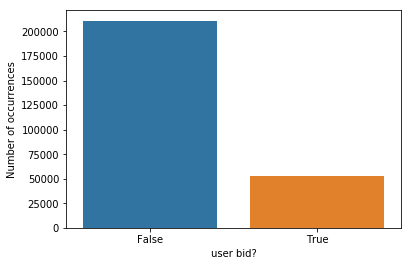

Has_bid percentage: 25.00%


In [66]:
#What is the distribution of has bid
sns.countplot(df.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

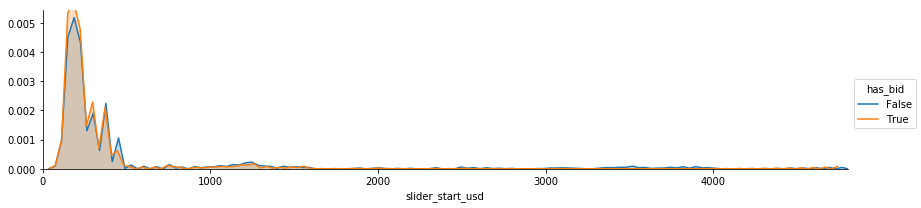

In [67]:
plot_distribution( df , var = 'slider_start_usd' , target = 'has_bid' )

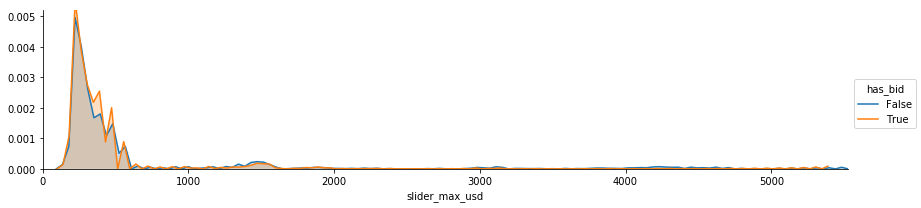

In [68]:
plot_distribution( df , var = 'slider_max_usd' , target = 'has_bid' )

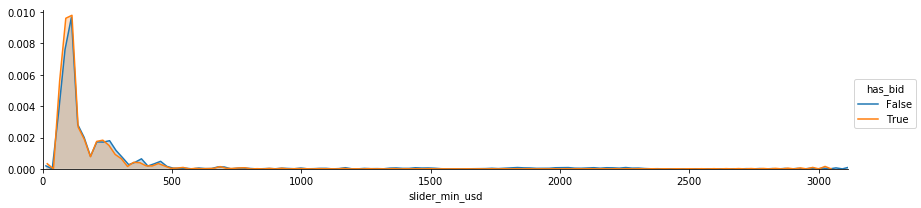

In [69]:
plot_distribution( df , var = 'slider_min_usd' , target = 'has_bid' )

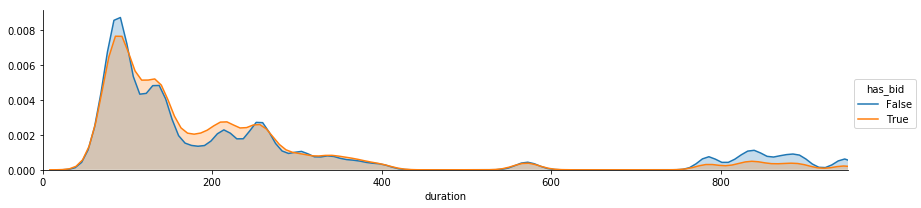

In [70]:
plot_distribution( df , var = 'duration' , target = 'has_bid' )

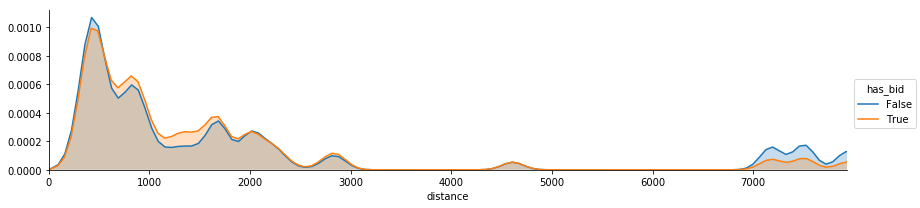

In [71]:
plot_distribution( df , var = 'distance' , target = 'has_bid' )

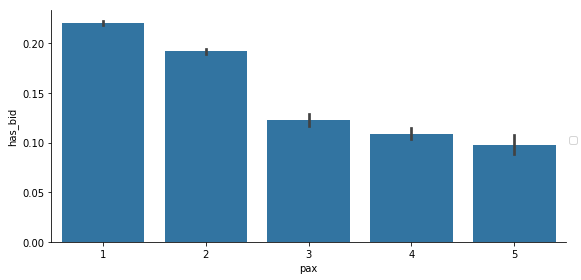

In [72]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

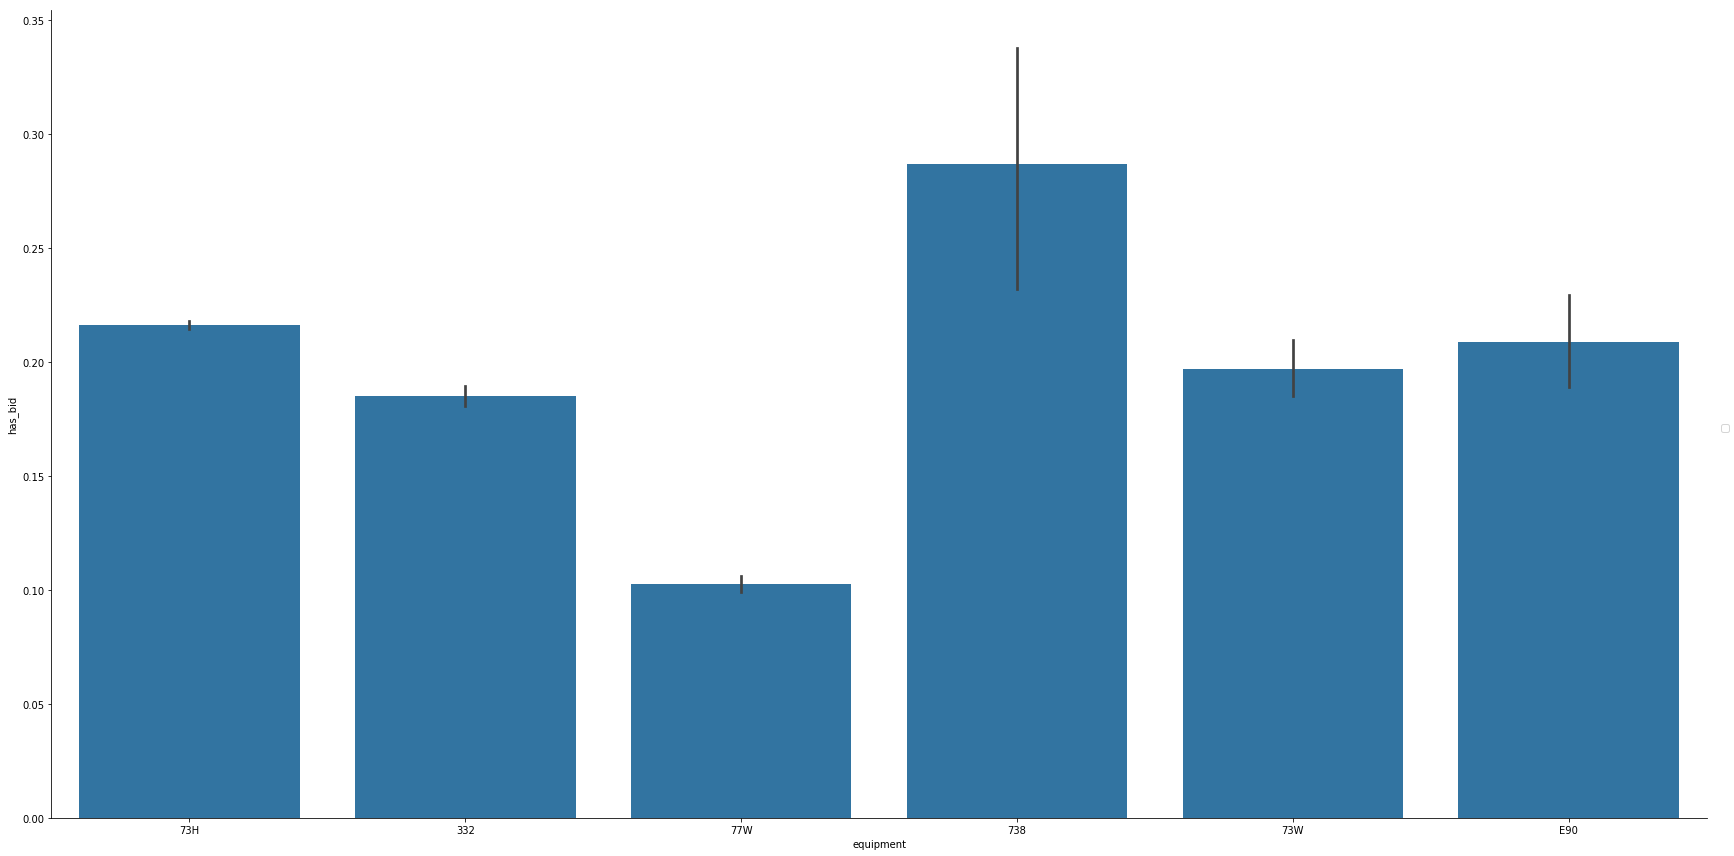

In [73]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

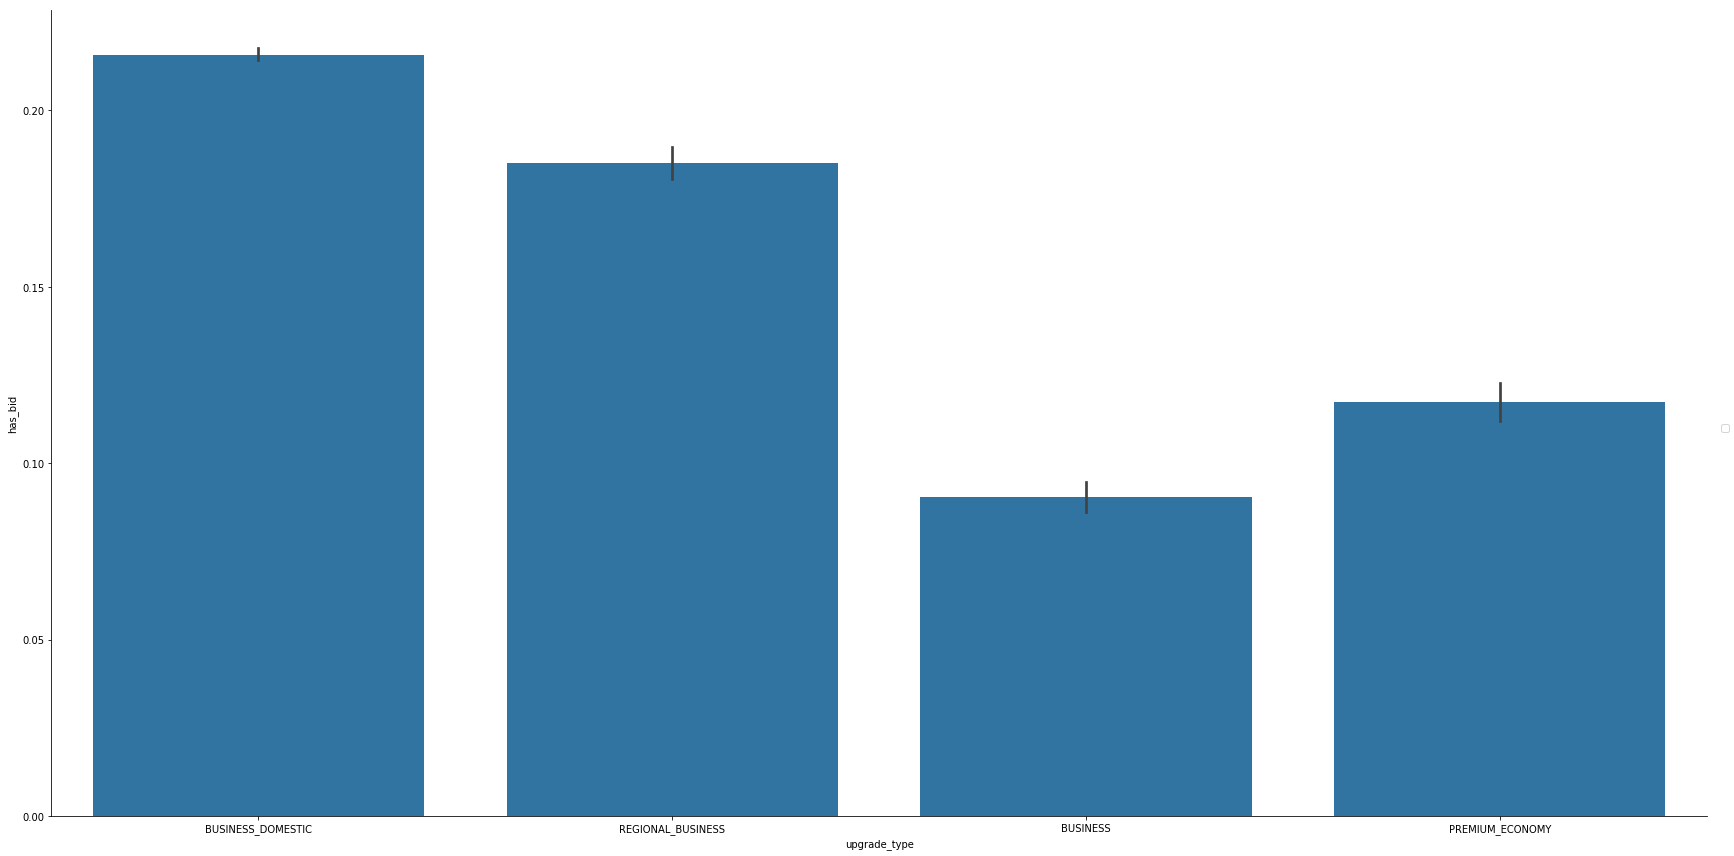

In [74]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

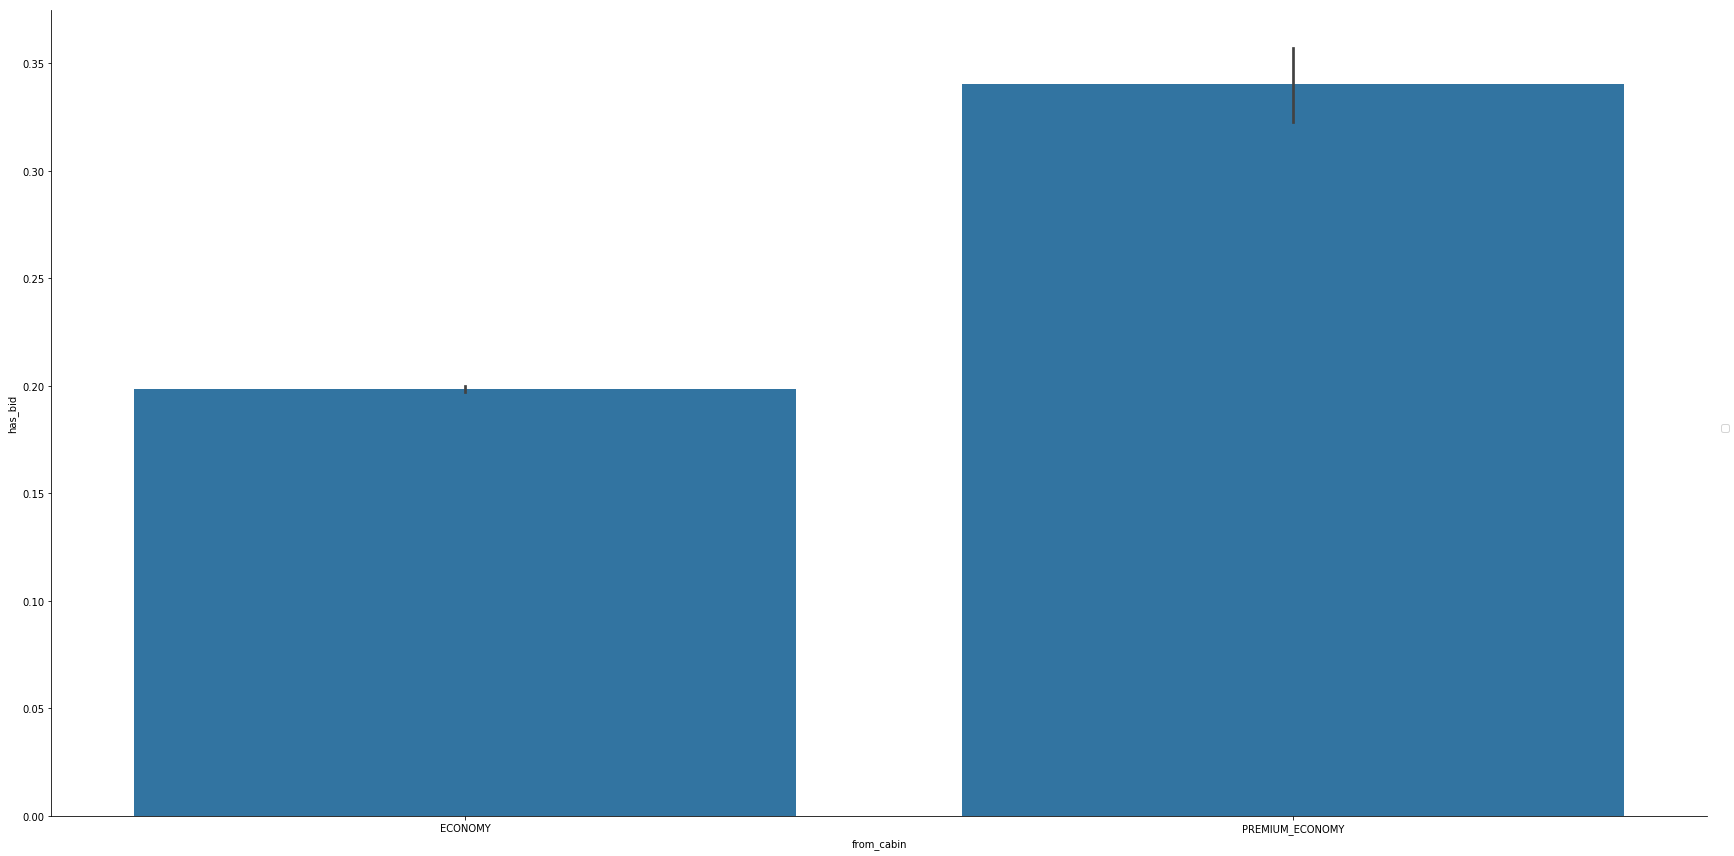

In [75]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

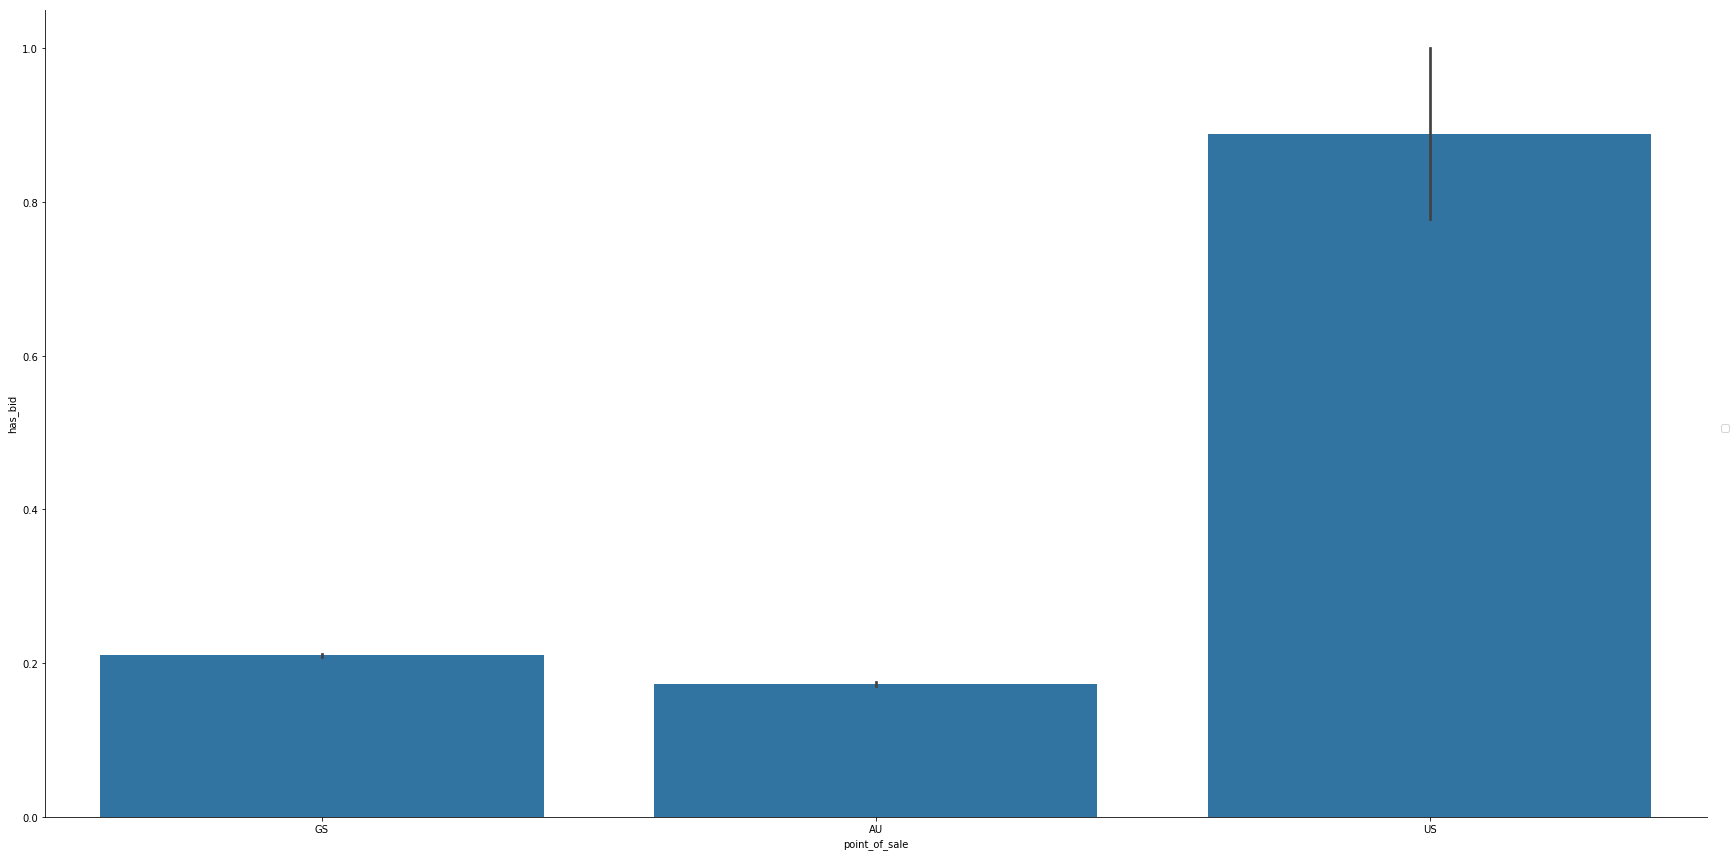

In [76]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

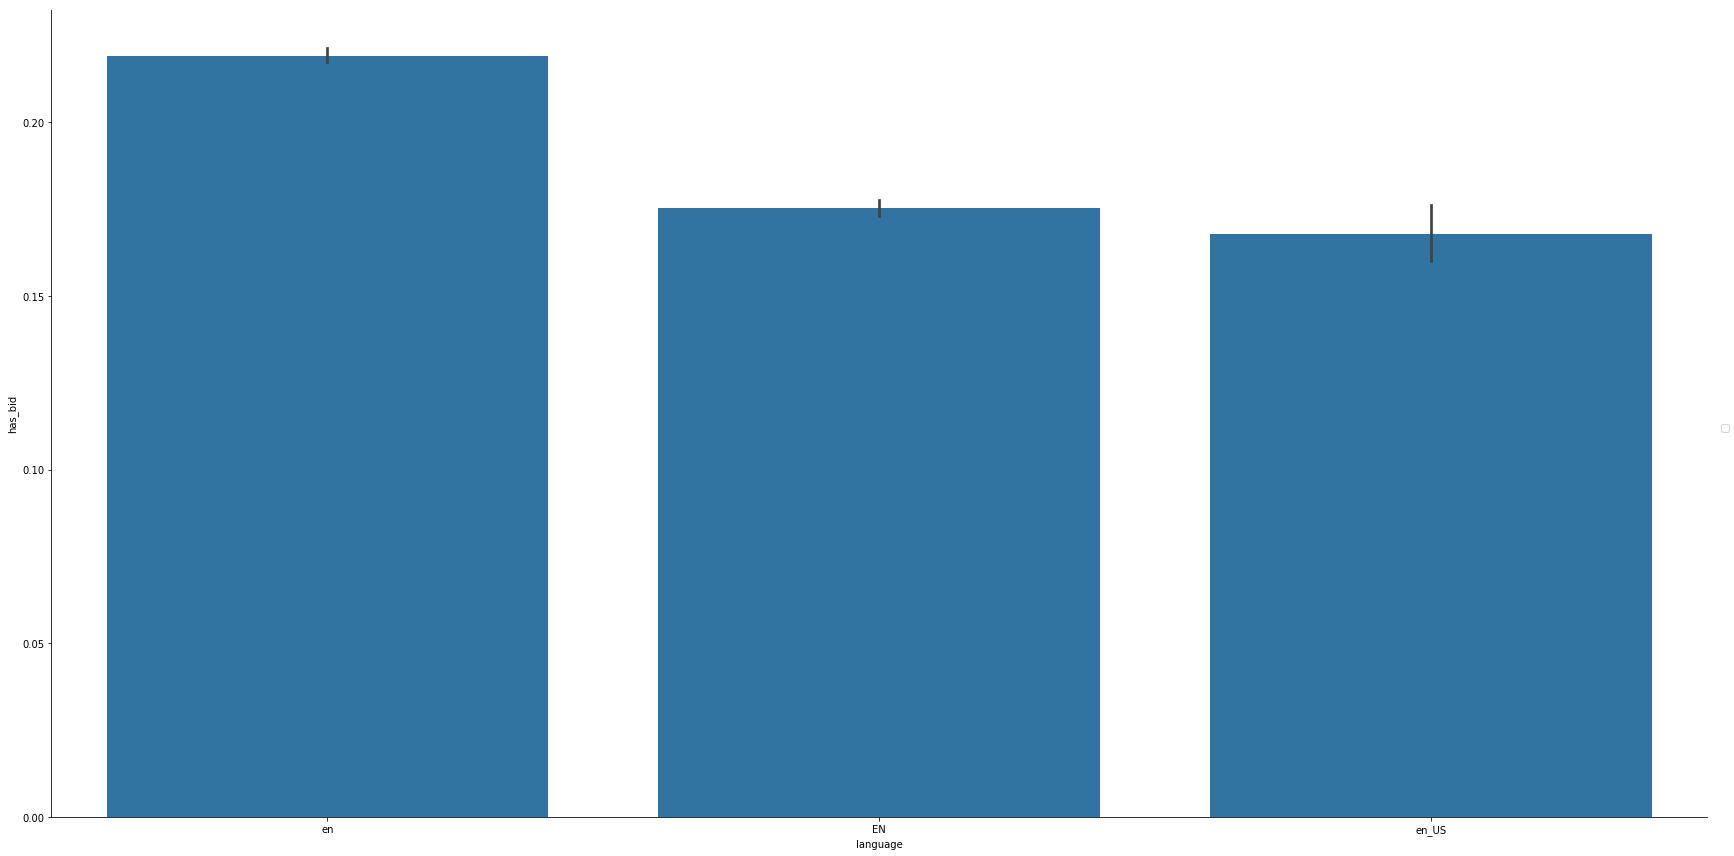

In [77]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [78]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263699 entries, 0 to 263698
Data columns (total 26 columns):
event_time          263699 non-null object
partner_id          263699 non-null int64
origin              263699 non-null object
destination         263699 non-null object
flight_number       263699 non-null float32
departure_date      263699 non-null object
departure_time      263699 non-null object
currency            263699 non-null object
language            263699 non-null object
pax                 263699 non-null float32
eligibility         263699 non-null bool
point_of_sale       263699 non-null object
channel_source      263699 non-null object
carrier_code        263699 non-null object
fare_class          263699 non-null object
from_cabin          263699 non-null object
upgrade_type        263699 non-null object
duration            263699 non-null float32
distance            263699 non-null float32
equipment           263699 non-null object
slider_max_usd      263699 n

### Prepare dataset

In [80]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
leOrigin = preprocessing.LabelEncoder()
leDestination = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    leDestination.fit(train_df_fact["destination"])
    train_df_fact["destination"] = leDestination.transform(train_df_fact["destination"])
    leOrigin.fit(train_df_fact["origin"])
    train_df_fact["origin"] = leOrigin.transform(train_df_fact["origin"])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [81]:
#factorize the categorical fields
columns_cat = ["equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [82]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263699 entries, 0 to 263698
Data columns (total 26 columns):
event_time          263699 non-null object
partner_id          263699 non-null int64
origin              263699 non-null int64
destination         263699 non-null int64
flight_number       263699 non-null int64
departure_date      263699 non-null object
departure_time      263699 non-null int64
currency            263699 non-null int64
language            263699 non-null int64
pax                 263699 non-null float32
eligibility         263699 non-null bool
point_of_sale       263699 non-null int64
channel_source      263699 non-null int64
carrier_code        263699 non-null int64
fare_class          263699 non-null int64
from_cabin          263699 non-null int64
upgrade_type        263699 non-null int64
duration            263699 non-null float32
distance            263699 non-null float32
equipment           263699 non-null int64
slider_max_usd      263699 non-null float3

## Create a model and evaluation

In [83]:
#Function utils
from sklearn.linear_model import LogisticRegression

random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


In [84]:
origins = train_df_fact.origin.unique()
destinations = train_df_fact.destination.unique()

def getTestDatasetsByRoute(testDatasetsX, testDatasetsY):
    datasetsByRouteX = []
    datasetsByRouteY = []
    origins_labels = []
    destinations_labels = []
    for i in origins:
        for j in destinations:
            idx = (testDatasetsX['origin'] == i) & (testDatasetsX['destination'] == j)
            datasetsByRouteX.append(testDatasetsX.loc[idx].copy())
            datasetsByRouteY.append(testDatasetsY.loc[idx].copy())
            origins_labels.append(i)
            destinations_labels.append(j)
    return datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels
    

def do_train_and_validate_by_route(df_to_train, n_splits = 2):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    X_train, X_valid, y_train, y_valid = train_test_split(x,y, test_size=0.30, random_state=42)
    random_forest.fit(X_train, y_train)
    datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels = getTestDatasetsByRoute(X_valid, y_valid)
    results = []
    for idx, val in enumerate(datasetsByRouteX):
        if (datasetsByRouteX[idx].shape[0] > 500):
            Y_test_pred = random_forest.predict_proba(datasetsByRouteX[idx])[:,1]
            fpr, tpr, _ = metrics.roc_curve(datasetsByRouteY[idx].astype(int), Y_test_pred)
            results.append([metrics.auc(fpr, tpr), leOrigin.inverse_transform(origins_labels[idx]), leDestination.inverse_transform(destinations_labels[idx])])
    results.sort(key=lambda x: x[0], reverse = True)
    for result in results:
        print("AUC = {}, ORIGIN = {}, DESTINATION = {}".format(result[0], result[1], result[2]))



### Feature engineering

In [85]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = train_df2.copy()

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


In [86]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263699 entries, 0 to 263698
Data columns (total 28 columns):
event_time               263699 non-null object
partner_id               263699 non-null int64
origin                   263699 non-null int64
destination              263699 non-null int64
flight_number            263699 non-null int64
departure_date           263699 non-null object
departure_time           263699 non-null int64
currency                 263699 non-null int64
language                 263699 non-null int64
pax                      263699 non-null float32
eligibility              263699 non-null bool
point_of_sale            263699 non-null int64
channel_source           263699 non-null int64
carrier_code             263699 non-null int64
fare_class               263699 non-null int64
from_cabin               263699 non-null int64
upgrade_type             263699 non-null int64
duration                 263699 non-null float32
distance                 263699 non-nu

In [87]:
train_df_3 = train_df_fact2.drop(["partner_id","eligibility", "departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "customer_id", "offer_amount"], axis=1)

In [88]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263699 entries, 0 to 263698
Data columns (total 18 columns):
origin                   263699 non-null int64
destination              263699 non-null int64
flight_number            263699 non-null int64
departure_time           263699 non-null int64
currency                 263699 non-null int64
pax                      263699 non-null float32
channel_source           263699 non-null int64
carrier_code             263699 non-null int64
fare_class               263699 non-null int64
duration                 263699 non-null float32
distance                 263699 non-null float32
equipment                263699 non-null int64
slider_max_usd           263699 non-null float32
slider_min_usd           263699 non-null float32
slider_start_usd         263699 non-null float32
has_bid                  263699 non-null bool
days_before_departure    263699 non-null int64
destination_origin       263699 non-null int64
dtypes: bool(1), float32(6), int

In [89]:
do_train_and_validate_by_route(train_df_3)

AUC = 0.7724570276742704, ORIGIN = LAX, DESTINATION = BNE
AUC = 0.762495114605605, ORIGIN = LAX, DESTINATION = SYD
AUC = 0.734694756290416, ORIGIN = BNE, DESTINATION = LAX
AUC = 0.7332790601155701, ORIGIN = LAX, DESTINATION = MEL
AUC = 0.721366634380333, ORIGIN = SYD, DESTINATION = LAX
AUC = 0.6881358493100092, ORIGIN = MEL, DESTINATION = LAX
AUC = 0.6690938679049712, ORIGIN = OOL, DESTINATION = SYD
AUC = 0.6644277123100895, ORIGIN = SYD, DESTINATION = OOL
AUC = 0.6543019033378678, ORIGIN = HBA, DESTINATION = MEL
AUC = 0.6541516384007369, ORIGIN = CNS, DESTINATION = BNE
AUC = 0.6426813707619395, ORIGIN = HKG, DESTINATION = MEL
AUC = 0.6414463868746241, ORIGIN = SYD, DESTINATION = BNE
AUC = 0.6403125360396725, ORIGIN = MEL, DESTINATION = HBA
AUC = 0.639109689213894, ORIGIN = MEL, DESTINATION = OOL
AUC = 0.6385063559322034, ORIGIN = MKY, DESTINATION = BNE
AUC = 0.6354963457467088, ORIGIN = MEL, DESTINATION = SYD
AUC = 0.6350827261537075, ORIGIN = BNE, DESTINATION = SYD
AUC = 0.6324808075